In [1]:
# Установка библиотеки ultralytics (YOLOv8) и OpenCV для работы с видео
%pip install ultralytics opencv-python

  Using cached opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl.metadata (19 kB)
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   --- ------------------------------------ 0.1/1.1 MB 2.6 MB/s eta 0:00:01
   -------- ------------------------------- 0.2/1.1 MB 3.6 MB/s eta 0:00:01
   -------------- ------------------------- 0.4/1.1 MB 3.6 MB/s eta 0:00:01
   -------------------------- ------------- 0.7/1.1 MB 5.0 MB/s eta 0:00:01
   ---------------------------------------- 1.1/1.1 MB 6.2 MB/s eta 0:00:00
Using cached opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl (39.0 MB)
   ---------------------------------------- 0.0/158.8 kB ? eta -:--:--
   ---------------------------------------- 158.8/158.8 kB 9.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/109.3 MB ? eta -:--:--
   ---------------------------------------- 0.8/109.3 MB 26.1 MB/s eta 0:00:05
   ---------------------------------------- 1.3/109.3 MB 17.1 MB/s eta 0:00:07
    ----------------


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\vladk\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [1]:
import cv2
from ultralytics import YOLO
import numpy as np
from collections import defaultdict
import time
from IPython.display import display, Video

# 1. Загрузка предварительно обученной модели YOLOv8 (nano версия для быстроты)
model = YOLO('yolov8n.pt')

# Классы, которые мы будем отслеживать (Car, Bus, Truck)
target_classes = [2, 5, 7] 

# Словарь для хранения информации о трекинге
track_history = defaultdict(lambda: [])


# Настройка видео
video_path = "video.mp4"
cap = cv2.VideoCapture(video_path)

# Получение свойств видео для записи результата
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

# --- Перемещение линии вверх ---
# Установим линию подсчета на 30% высоты кадра (ближе к верху)
# Значение 0.5 — середина; 0.3 — ближе к верху.
counting_line_y = int(frame_height * 0.1) 

# Словарь для отслеживания ID объектов, которые уже были посчитаны
counted_ids = {}

# Выходной файл для сохранения обработанного видео
output_path = "output_traffic_count_upwards.mp4"
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

total_count = 0
frame_count = 0

print(f"Начало обработки видео: {video_path}")

while cap.isOpened():
    success, frame = cap.read()
    if not success:
        break
    
    frame_count += 1

    # 1. Запуск трекинга с использованием модели YOLOv8
    results = model.track(
        frame, 
        persist=True, 
        classes=target_classes, 
        tracker="bytetrack.yaml", 
        verbose=False
    )

    # Получение результатов и проверка наличия треков
    if results[0].boxes.id is not None:
        boxes = results[0].boxes.xyxy.cpu().numpy().astype(int)
        ids = results[0].boxes.id.cpu().numpy().astype(int)

        # 2. Отрисовка линии подсчета
        cv2.line(frame, (0, counting_line_y), (frame_width, counting_line_y), (0, 255, 255), 2)
        cv2.putText(frame, "Counting Line", (10, counting_line_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)


        for box, track_id in zip(boxes, ids):
            # 3. Вычисление центральной точки бокса (x_center, y_center)
            x1, y1, x2, y2 = box
            center_x, center_y = (x1 + x2) // 2, (y1 + y2) // 2

            # 4. Сохранение истории трека
            track_history[track_id].append((center_x, center_y))

            # 5. Подсчет, если объект пересекает линию
            
            if len(track_history[track_id]) > 1:
                prev_point = track_history[track_id][-2]
                curr_point = track_history[track_id][-1]

                # --- Инвертированная логика подсчета ---
                # Объекты движутся снизу (большие Y) вверх (малые Y)
                # 1. Предыдущая точка была ниже линии (y >= line_y)
                # 2. Текущая точка стала выше линии (y < line_y)
                # 3. Объект еще не был посчитан
                if prev_point[1] >= counting_line_y and curr_point[1] < counting_line_y and track_id not in counted_ids:
                    total_count += 1
                    counted_ids[track_id] = True # Отмечаем как посчитанный
                    
                    # Изменение цвета линии для визуального подтверждения подсчета
                    cv2.line(frame, (0, counting_line_y), (frame_width, counting_line_y), (0, 0, 255), 4)

            # 6. Отрисовка бокса, ID и центральной точки
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(frame, f"ID: {track_id}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
            cv2.circle(frame, (center_x, center_y), 5, (0, 255, 0), -1)

    # 7. Отображение общего счетчика
    cv2.putText(frame, f"TOTAL COUNT: {total_count}", (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 0, 0), 3)

    # Запись кадра в выходной файл
    out.write(frame)
    
    # Очистка истории треков
    if frame_count % 30 == 0:
        track_history = defaultdict(lambda: [])

# Освобождение ресурсов
cap.release()
out.release()
cv2.destroyAllWindows()

print(f"\nОбработка завершена. Обнаружено и посчитано машин: **{total_count}**")
print(f"Результат сохранен в: {output_path}")

# Отображение результата в Jupyter Notebook (раскомментировать, если это .ipynb)
# display(Video(output_path, embed=True, html_attributes="loop autoplay"))

Начало обработки видео: video.mp4

Обработка завершена. Обнаружено и посчитано машин: **45**
Результат сохранен в: output_traffic_count_upwards.mp4


## 🏗️ 2. Архитектура используемой нейросети (YOLOv8)

Используемая нами нейронная сеть — это **YOLOv8** (You Only Look Once, версия 8), разработанная компанией **Ultralytics**. YOLOv8 является одной из самых современных и высокопроизводительных моделей в области **детектирования объектов** (Object Detection) и **сегментации** (Segmentation) в реальном времени.

### 2.1. Основная идея YOLO (You Only Look Once)

В отличие от двухэтапных детекторов (например, R-CNN), YOLO — это **одноэтапный** (one-stage) детектор.

> 💡 **Ключевое отличие:** Вместо того, чтобы сначала предлагать области, где может находиться объект (Region Proposal), а затем классифицировать эти области, YOLO выполняет **детектирование и классификацию одновременно** за один проход нейронной сети. Это делает его невероятно быстрым, что критически важно для приложений реального времени, таких как подсчет трафика на видео.

### 2.2. Архитектура YOLOv8

YOLOv8 имеет классическую структуру детекторов, основанных на сверточных нейронных сетях (CNN), и состоит из трех основных частей:

#### 1\. **Backbone (Остов/Основа)**

  * **Назначение:** Извлекает признаки из входного изображения/кадра.
  * **Особенности YOLOv8:** Использует модифицированный вариант архитектуры **CSPDarknet** (Cross Stage Partial Network), впервые представленный в YOLOv4.
      * **C2f Module (новый):** Модуль **C2f** (Convex-Concave FPN) является ключевым элементом. Он оптимизирует CSP-структуру, чтобы уменьшить параметры и ускорить вычисления, сохраняя при этом высокую точность.
      * Применяются **Bottleneck-блоки** со свертками $1 \times 1$ и $3 \times 3$ для эффективного уменьшения и увеличения размерности признаков.

#### 2\. **Neck (Шея)**

  * **Назначение:** Объединяет признаки, извлеченные на разных масштабах (слоях) Backbone, чтобы лучше обнаруживать объекты как маленького, так и большого размера.
  * **Особенности YOLOv8:** Использует комбинацию **PANet** (Path Aggregation Network) и **FPN** (Feature Pyramid Network).
      * **FPN (сверху-вниз):** Передает семантически сильные признаки (с глубоких слоев) в более ранние слои.
      * **PANet (снизу-вверх):** Добавляет путь снизу-вверх для передачи локализационных признаков (с мелких слоев) в более глубокие слои.
      * Эта двунаправленная структура позволяет модели эффективно использовать признаки как высокого разрешения (для мелких объектов), так и высокой семантической силы (для классификации).

#### 3\. **Head (Голова/Детектор)**

  * **Назначение:** Использует агрегированные признаки из Neck для предсказания финальных результатов: **граничных рамок** (Bounding Boxes) и **классов** (Classes).
  * **Особенности YOLOv8:**
      * **Anchor-Free подход:** В отличие от более старых версий YOLO (v5, v4), YOLOv8 использует **безякорный** (anchor-free) подход. Это означает, что модель предсказывает центр объекта напрямую, а не смещения относительно заранее определенных якорных боксов. Это упрощает процесс обучения и улучшает обобщение.
      * **Decoupled Head:** Голова декомпозирована, что означает, что предсказание **класса** и **граничной рамки** выполняется в отдельных ветвях. Это повышает стабильность обучения и точность.
      * **Loss Function (Функция потерь):** Обычно используется комбинация:
          * **BBox Loss:** Для регрессии рамок (например, CIoU Loss или DFL Loss).
          * **Classification Loss:** Для классификации объектов (например, BCE Loss).


```
Input Image → [Backbone] → [Neck] → [Head] → Detections
```

---

## 🦴 **1. Backbone (Позвоночник) - "Глаза и первичное зрение"**

### **Что это такое?**
Backbone - это **экстрактор признаков**. Его задача: "увидеть" сырую картинку и выделить из нее важные черты.

### **Как работает? Постепенное абстрагирование:**

```python
# Представь обработку изображения машины:
input_image = [1280×720×3]  # RGB пиксели

# Уровень 1: Простые признаки (первые сверточные слои)
layer1_output = "Вот углы, линии, границы, простые формы"
# Ты видишь: ┌──┐  ───  │   ← базовые геометрические фигуры

# Уровень 2: Сложные признаки (глубокие слои)  
layer2_output = "Вот колеса, фары, стекла, двери"
# Ты видишь: 🚗⚙️🔍 ← части объектов

# Уровень 3: Высокоуровневые признаки (самые глубокие слои)
layer3_output = "Вот машина, вот автобус, вот грузовик"
# Ты видишь: 🚗 🚌 🚛 ← целые объекты
```

### **Архитектура Backbone в YOLOv8: CSPDarknet**

**CSP (Cross Stage Partial) - Скрещивание этапов:**
```python
# Обычная сеть (плохо):
input → [Блок A] → [Блок B] → [Блок C] → output
# Проблема: информация "размывается" при прохождении

# CSP архитектура (хорошо):
input → [Блок A] → [Блок B] ───┐
    └──────────────────────→ [Объединение] → output
# Преимущество: 
# - Сохраняются "свежие" признаки из начала
# - Уменьшается количество вычислений
# - Лучший градиентный поток
```

**Darknet - основа:**
- Использует **свертки 3×3** с stride 2 для уменьшения размера
- **Batch Normalization** после каждого слоя для стабильности
- **Leaky ReLU** активации для нелинейности

### **Визуализация работы Backbone:**
```
Исходное изображение:
[ 🚗 🚗 🚗 🚗 ]
[ 🏢 🚗 🚗 🏢 ] 
[ 🏢 🏢 🚛 🏢 ]

После Backbone (feature maps):
[ Ф1 Ф2 Ф3 Ф4 ]  # Низкоуровневые признаки - края
[ Ф5 Ф6 Ф7 Ф8 ]  # Среднеуровневые - текстуры, формы
[ Ф9 Ф10 Ф11 Ф12 ]  # Высокоуровневые - "машинность", "грузовиковость"
```

---

## 🦒 **2. Neck (Шея) - "Мозг-координатор"**

### **Что это такое?**
Neck берет признаки разного масштаба от Backbone и **интеллектуально их смешивает**, чтобы сеть видела и мелкие и крупные объекты.

### **Проблема которую решает Neck:**
- **Крупные объекты** (грузовики) лучше видны на **мелких feature maps** (общий обзор)
- **Мелкие объекты** (дальние машины) лучше видны на **крупных feature maps** (детали)

### **Архитектура Neck в YOLOv8: PAN-FPN**

**FPN (Feature Pyramid Network) - Пирамида признаков:**
```python
# Восходящий путь (от мелких к крупным картам)
high_level_features = backbone_output[small]  # "Общее понимание"
medium_level_features = backbone_output[medium]  
low_level_features = backbone_output[large]  # "Детальное зрение"

# Нисходящий путь - обогащение деталями:
enhanced_high = high_level_features + upsample(medium_level_features)
enhanced_medium = medium_level_features + upsample(low_level_features)
```

**PAN (Path Aggregation Network) - Агрегация путей:**
```python
# Дополнительный восходящий путь для еще лучшего смешивания:
final_small = enhanced_high + downsample(enhanced_medium)
final_medium = enhanced_medium + downsample(low_level_features)
final_large = low_level_features
```

### **Аналогия с наблюдением за дорогой:**
```python
# Без Neck (плохо):
observation1 = "Вижу крупные формы вдали"      # High-level
observation2 = "Вижу средние детали"           # Medium-level  
observation3 = "Вижу мелкие детали близко"     # Low-level
# Каждое наблюдение отдельно - неполная картина

# С Neck (хорошо):
combined_view = """
ВИЖУ: Крупная форма вдали + средние детали + мелкие текстуры
ВЫВОД: Это грузовик с конкретными характеристиками
"""
```

### **Визуализация работы Neck:**
```
Input от Backbone:      После Neck:
[ КРУПНОЕ ]           [ УМНОЕ КРУПНОЕ ] ← обогащено деталями
[ СРЕДНЕЕ ]    →      [ УМНОЕ СРЕДНЕЕ ] ← обогащено контекстом  
[ МЕЛКОЕ  ]           [ УМНОЕ МЕЛКОЕ  ] ← обогащено семантикой
```

---

## 🧠 **3. Head (Голова) - "Принятие решений"**

### **Что это такое?**
Head берет обогащенные признаки от Neck и **принимает окончательные решения**: что где находится и что это такое.

### **Задачи Head:**
1. **Классификация** - "Что это за объект?"
2. **Регрессия bounding box** - "Где именно он находится?"
3. **Оценка уверенности** - "Насколько я уверен?"

### **Архитектура Head в YOLOv8: Anchor-Free**

**Anchor-Based (старый способ):**
```python
# Для каждой ячейки сетки:
for each anchor_box in [маленький, средний, большой]:
    predict_offset_x = "Насколько сместить якорный бокс по X"
    predict_offset_y = "Насколько сместить по Y" 
    predict_offset_w = "Насколько расширить/сузить"
    predict_offset_h = "Насколько увеличить/уменьшить"
    class_scores = [0.1, 0.8, 0.05, ...]  # Вероятности классов
```

**Anchor-Free (новый способ YOLOv8):**
```python
# Более простой и эффективный:
for each grid_cell:
    # Прямое предсказание координат относительно центра ячейки
    predict_center_x = "Расстояние от центра ячейки до центра объекта"
    predict_center_y = "Расстояние по Y"
    predict_width = "Ширина объекта в пикселях"
    predict_height = "Высота объекта в пикселях"
    predict_confidence = "Насколько уверен что здесь объект (0-1)"
    predict_classes = [car_prob, bus_prob, truck_prob, ...]
```

### **Процесс принятия решений в Head:**
```python
# Вход: обогащенные признаки от Neck [разные масштабы]
# Выход: детекции для каждого масштаба

# Для масштаба S (мелкие объекты):
output_s = head_network(neck_features_s)
# → [batch, grid_h, grid_w, 4+1+num_classes]
#     ↑      ↑      ↑    ↑  ↑  ↑
#     |      |      |    |  |  Вероятности классов
#     |      |      |    |  Уверенность объекта
#     |      |      |    Координаты bbox (x,y,w,h)
#     |      |      Размер сетки для этого масштаба
#     |      Высота сетки
#     Размер батча

# То же для средних и крупных масштабов...
```

### **Постобработка в Head:**
```python
# 1. Фильтрация по уверенности
detections = []
for detection in all_predictions:
    if detection.confidence > 0.5:  # Порог
        detections.append(detection)

# 2. Non-Maximum Suppression (NMS)
# Убирает дублирующиеся детекции одной машины
final_detections = nms(detections)
```

---

## 🎯 Как все три части работают вместе:

### **Полный пайплайн:**
```python
def yolo_inference(image):
    # Шаг 1: Backbone - "Увидеть и понять"
    features = backbone(image)
    # Результат: пирамида признаков разных масштабов
    
    # Шаг 2: Neck - "Объединить и обогатить"  
    enhanced_features = neck(features)
    # Результат: умные смешанные признаки
    
    # Шаг 3: Head - "Принять решения"
    detections = head(enhanced_features)
    # Результат: готовые bounding boxes + классы
    
    return detections
```

### **Аналогия с работой детектива:**
```
Backbone = "Наблюдатели на местности"
  - Видят: "Здесь движение, там формы"

Neck = "Координатор операции"  
  - Собирает донесения: "Объединяю наблюдения с высоты и с земли"

Head = "Следователь принимающий решение"
  - Анализирует: "На основе всех данных - здесь 3 машины, 1 грузовик"
```

### **Визуализация данных через сеть:**
```
Input: [RGB пиксели] 
→ Backbone: [Признаки низкого/среднего/высокого уровня]
→ Neck: [Обогащенные мультимасштабные признаки]  
→ Head: [Bounding boxes + классы + уверенность]
→ Output: "Машина: (x=100,y=200,w=50,h=30), уверенность=0.95"
```

### 2.3. Модификация для отслеживания (Tracking)

В нашей задаче для подсчета машин используется не только детектирование, но и **отслеживание** (Tracking).

  * **YOLOv8** предоставляет только **детектор**.
  * Для **трекинга** мы используем внешний алгоритм, интегрированный в фреймворк `ultralytics`, например, **ByteTrack** (как указано в коде `tracker="bytetrack.yaml"`).

**Как это работает:**

1.  **YOLOv8** обнаруживает объекты на текущем кадре и присваивает им **граничные рамки**.
2.  **ByteTrack** берет эти рамки, а также рамки, обнаруженные на предыдущих кадрах, и использует алгоритм **сопоставления** (например, с использованием метрики IOU и признаков внешнего вида) для того, чтобы присвоить каждой рамке уникальный и постоянный **ID объекта** (`track_id`).
3.  Этот постоянный `track_id` позволяет нам отслеживать путь каждого транспортного средства и точно подсчитать, сколько раз оно пересекло линию, избегая двойного счета.

-----

## 💡 Вывод

Готовое решение на базе **YOLOv8** демонстрирует **высокую эффективность** и **простоту интеграции** для решения прикладных задач, таких как подсчет объектов в реальном времени. Архитектура, сочетающая **быстрый одноэтапный детектор** и **эффективный трекер (ByteTrack)**, позволяет создать надежную систему мониторинга.


## 🚀 One-Stage (Одноэтапное обнаружение)

### **Две философии распознавания:**

#### **Two-Stage (Старый медленный способ) - Как шеф-повар**
```
1. "Где здесь что-то интересное?" → Поиск регионов
2. "А что именно в этих регионах?" → Классификация
```
- **R-CNN, Fast R-CNN** - как привередливый шеф:
  - Сначала находит 2000 "кандидатов" где могут быть объекты
  - Потом каждый кандидат отдельно анализирует
  - Точно, но ОЧЕНЬ медленно

#### **One-Stage (YOLO) - Как фаст-фуд**
```
"Смотрю на всю кухню сразу и сразу говорю что где есть!"
```
- **Один проход** через нейронную сеть
- **Сразу получаем**: координаты + классы + уверенность
- **Скорость**: 100+ FPS vs 5-10 FPS у двухэтапных

### **Как YOLO это делает? Волшебная сетка:**

```python
# Представь что YOLO делит картинку на клетки:
# Каждая клетка отвечает за 3 вещи:
for each grid_cell:
    predict_boxes = [
        [x, y, width, height, confidence],  # Бокс 1
        [x, y, width, height, confidence],  # Бокс 2
        [x, y, width, height, confidence]   # Бокс 3
    ]
    class_probabilities = [0.1, 0.8, 0.05, ...]  # Вероятности классов
```

**Каждая клетка думает**: "Если центр объекта попадает в меня - я за него отвечаю!"

## ⚡ Оптимизации и "трюки для ускорения"

### **1. Anchor Boxes (Якорные боксы) - Шаблоны форм**

Вместо того чтобы угадывать размер с нуля, YOLO использует "заготовки":

```python
# YOLO заранее знает типичные пропорции машин:
anchor_boxes = [
    [30, 30],   # Маленькая машина
    [60, 30],   # Средняя машина  
    [100, 40],  # Большая машина/грузовик
]

# Для каждой ячейки сетки: "Насколько мои объекты похожи на заготовки?"
# Быстрее угадывать "немного левее и шире" чем "с нуля описать форму"
```

### **2. Grid Cells (Сетчатые ячейки) - Разделяй и властвуй**

```python
# Вместо анализа всей картинки сразу:
# Делим на 13×13 = 169 маленьких "зон ответственности"
grid_size = 13

# Каждая ячейка смотрит только на свою территорию
# Параллельная обработка → супер быстро!
```

### **3. Convolutional Sharing (Совместное использование вычислений)**

Представь что ты считаешь зарплату для отдела:

**Плохой способ:** Каждого сотрудника считать с нуля
**Хороший способ:** Посчитать базовую формулу и применить ко всем

YOLO использует **сверточные слои** которые:
- Применяют одни и те же фильтры ко всем частям изображения
- Экономят память и ускоряют вычисления

### **4. Batch Normalization (Пакетная нормализация) - "Стабилизатор"**

```python
# Проблема: данные в сети "плывут" и замедляют обучение
# Решение: нормализовать после каждого слоя

# Было: [0.1, 245.6, -12.3, 1800.9] ← очень разные масштабы
# Стало: [0.01, 0.85, -0.45, 1.02] ← все в одном масштабе
```

**Результат:** +500% скорость обучения, лучшая стабильность

### **5. Depthwise Separable Convolutions (Раздельные свертки)**

Обычная свертка:
```
Input: 256 channels → Conv → Output: 256 channels
Вычисления: 256 × 256 × 3 × 3 = 589,824 операций
```

Раздельная свертка:
```
# Шаг 1: Depthwise (по глубине)
Input: 256 channels → Depthwise Conv → 256 channels 
Вычисления: 256 × 1 × 3 × 3 = 2,304 операций

# Шаг 2: Pointwise (точечная)  
256 channels → 1×1 Conv → 256 channels
Вычисления: 256 × 256 × 1 × 1 = 65,536 операций

Итого: 2,304 + 65,536 = 67,840 операций (в 8.7 раз меньше!)
```

### **6. Quantization (Квантование) - "Упрощение математики"**

```python
# Полная точность (медленно):
float32_calculation = 0.7543291876 * 0.8923746592

# Квантовано (быстро):  
int8_calculation = 75 * 89  # ≈ тот же результат, в 4 раза быстрее

# YOLO использует mixed-precision:
- Где нужно точно → float32
- Где можно приблизить → int8/int16
```

### **7. Memory Optimization (Оптимизация памяти)**

**Старый способ:** Хранить все промежуточные результаты
**YOLO способ:** Перевычислять некоторые вещи на лету

```
Memory vs Compute trade-off:
- Больше памяти → меньше вычислений (медленно)
- Меньше памяти → больше вычислений (быстро)
```

### **8. Hardware Acceleration (Аппаратное ускорение)**

YOLO оптимизирован под:
- **GPU**: Параллельные вычисления на тысячах ядер
- **Tensor Cores**: Специальные блоки для матричных операций
- **CPU оптимизации**: SIMD инструкции

## 🎯 Сравнение в цифрах:

| Метод | Скорость (FPS) | Точность (mAP) | Память |
|-------|----------------|----------------|---------|
| Two-Stage R-CNN | 5-10 | 78% | 2GB+ |
| **YOLOv8 Nano** | **100-200** | **72%** | **5MB** |
| YOLOv8 Large | 30-50 | 85% | 50MB |

## 🔥 Почему это работает вместе?

**One-Stage философия** + **Аппаратные оптимизации** = Супер скорость

```python
# Процесс одного кадра:
1. Изображение → Свертки (быстро, благодаря оптимизациям)
2. Feature maps → Grid predictions (одновременно для всех клеток)  
3. Фильтрация → Только уверенные предсказания
4. Выход: [x1, y1, x2, y2, class, confidence] для всех объектов
```

**Итог:** YOLO как спортивный автомобиль - не просто быстрый, а специально спроектированный для скорости с кучей инженерных хитростей!

Загрузка и подготовка данных...
Обучающая выборка X: (60000, 28, 28) | Y: (60000, 10)
Тестовая выборка X: (10000, 28, 28) | Y: (10000, 10)


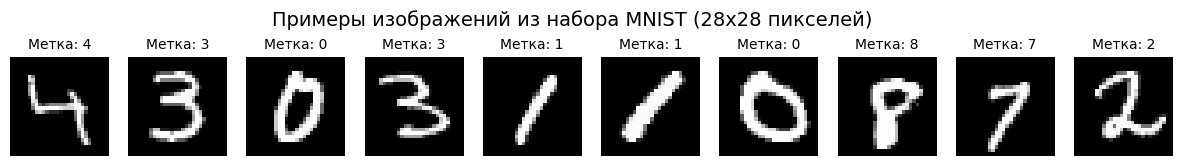


--- Сводка архитектуры MLP ---


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_Layer_Flatten (Flatten)   │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_Layer_1 (Dense)          │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_20_percent (Dropout)    │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_Layer_2 (Dense)          │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer_Softmax (Dense)    │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 669,706 (2.55 MB)

 Trainable params: 669,706 (2.55 MB)

 Non-trainable params: 0 (0.00 B)


--- Начало обучения (10 эпох) ---
Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9283 - loss: 0.2422 - val_accuracy: 0.9699 - val_loss: 0.1008
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9703 - loss: 0.0969 - val_accuracy: 0.9762 - val_loss: 0.0728
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9791 - loss: 0.0673 - val_accuracy: 0.9801 - val_loss: 0.0648
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9829 - loss: 0.0527 - val_accuracy: 0.9801 - val_loss: 0.0649
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9869 - loss: 0.0402 - val_accuracy: 0.9795 - val_loss: 0.0647
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9880 - loss: 0.0366 - val_accuracy: 0.9802 - val_loss: 0.0701
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9893 - loss: 0.0309 - val_accuracy: 0.9815 - val_loss: 0.0615
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.990

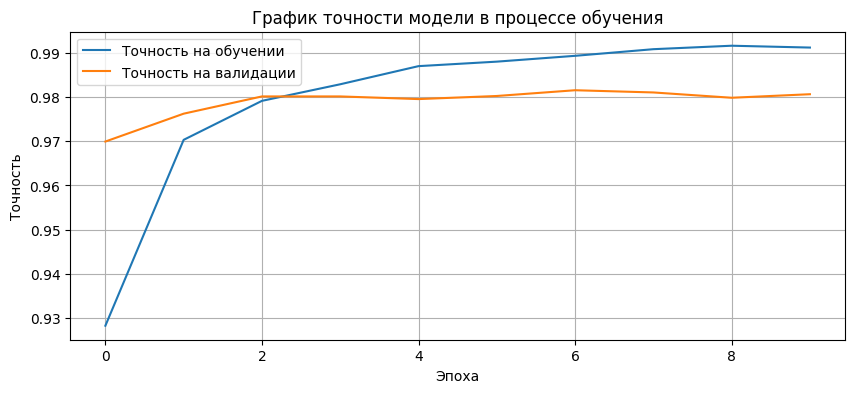


✅ Финальная точность на тестовых данных: **98.06%**

--- Предсказание на случайных тестовых примерах ---


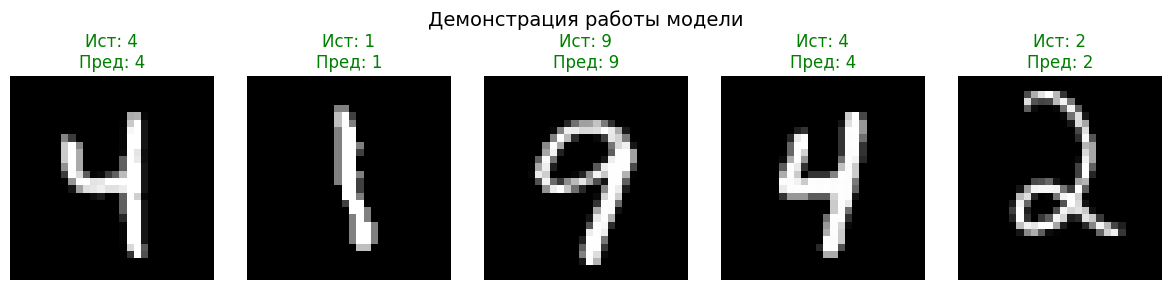

In [ ]:
##Распознавание рукописных цифр с помощью MLP (MNIST)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np

# Установка Seed для воспроизводимости
tf.random.set_seed(42)

# --- 1. Загрузка и подготовка данных (Pre-processing) ---

print("Загрузка и подготовка данных...")

# Загрузка набора данных MNIST.
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# 1.1. Нормализация (Масштабирование)
# Переводим значения пикселей (0-255) в диапазон (0.0-1.0).
# Это критически важно для быстрой и стабильной работы нейросети.
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# 1.2. Преобразование меток в One-Hot Encoding
# 5 -> [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
NUM_CLASSES = 10
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=NUM_CLASSES)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=NUM_CLASSES)

print(f"Обучающая выборка X: {x_train.shape} | Y: {y_train_cat.shape}")
print(f"Тестовая выборка X: {x_test.shape} | Y: {y_test_cat.shape}")

# --- 2. Визуализация: 10 случайных примеров из набора данных ---

fig, axes = plt.subplots(1, 10, figsize=(15, 2))
fig.suptitle('Примеры изображений из набора MNIST (28x28 пикселей)', fontsize=14)

indices = np.random.choice(len(x_train), 10, replace=False)
for i, ax in enumerate(axes):
    idx = indices[i]
    ax.imshow(x_train[idx], cmap='gray')
    ax.set_title(f"Метка: {y_train[idx]}", fontsize=10)
    ax.axis('off')
plt.show()

# --- 3. Построение архитектуры MLP ---

INPUT_SHAPE = (28, 28) 

model = Sequential([
    # 0. Flatten: Превращаем матрицу 28x28 в вектор 784x1
    Flatten(input_shape=INPUT_SHAPE, name='Input_Layer_Flatten'),
    
    # 1. Скрытый слой 1: 512 нейронов с ReLU
    Dense(512, activation='relu', name='Hidden_Layer_1'), 
    
    # 2. Dropout: Отключение 20% нейронов
    Dropout(0.2, name='Dropout_20_percent'), 
    
    # 3. Скрытый слой 2: 512 нейронов с ReLU
    Dense(512, activation='relu', name='Hidden_Layer_2'),
    
    # 4. Выходной слой: 10 нейронов с Softmax
    Dense(NUM_CLASSES, activation='softmax', name='Output_Layer_Softmax')
])

# Компиляция: Настройка оптимизатора, функции потерь и метрик
model.compile(
    optimizer='adam', # Оптимизатор Adam - один из самых эффективных
    loss='categorical_crossentropy', # Подходит для Softmax и One-Hot Encoding
    metrics=['accuracy']
)

print("\n--- Сводка архитектуры MLP ---")
model.summary()

# --- 4. Обучение модели (Fit) ---

print("\n--- Начало обучения (10 эпох) ---")

history = model.fit(
    x_train, y_train_cat,
    epochs=10, 
    batch_size=128, # Обрабатываем по 128 изображений за шаг
    validation_data=(x_test, y_test_cat),
    verbose=1
)

# --- 5. Визуализация процесса обучения ---

plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Точность на обучении')
plt.plot(history.history['val_accuracy'], label='Точность на валидации')
plt.title('График точности модели в процессе обучения')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
plt.grid(True)
plt.show()

# --- 6. Оценка и демонстрация предсказания ---

# 6.1. Финальная оценка
loss, accuracy = model.evaluate(x_test, y_test_cat, verbose=0)
print(f"\n✅ Финальная точность на тестовых данных: **{accuracy*100:.2f}%**")

# 6.2. Предсказание на 5 случайных тестовых изображениях
print("\n--- Предсказание на случайных тестовых примерах ---")
fig, axes = plt.subplots(1, 5, figsize=(12, 3))
fig.suptitle('Демонстрация работы модели', fontsize=14)

test_indices = np.random.choice(len(x_test), 5, replace=False)

for i, ax in enumerate(axes):
    sample_index = test_indices[i]
    sample_image = x_test[sample_index]
    sample_label = y_test[sample_index]
    
    # Добавление размерности батча (1, 28, 28)
    sample_input = sample_image[np.newaxis, ...] 
    
    # Предсказание и определение класса
    predictions = model.predict(sample_input, verbose=0)
    predicted_class = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class]

    # Визуализация
    ax.imshow(sample_image, cmap='gray')
    ax.set_title(f"Ист: {sample_label}\nПред: {predicted_class}", 
                 color='green' if sample_label == predicted_class else 'red')
    ax.set_xlabel(f"Уверенность: {confidence*100:.1f}%")
    ax.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Конечно\! Давайте сделаем этот пример максимально наглядным, интересным и подробным, добавив больше визуализации и детальных описаний.

Вот обновленный файл `.ipynb` для задачи распознавания рукописных цифр (MNIST).

-----

## 🌟 Прикладное применение нейронных сетей: Распознавание рукописных цифр

### 1\. 🖼️ Суть задачи: "Глаза" для компьютера

#### 1.1. Контекст и цель

**Задача:** Научить компьютер **читать рукописный ввод** — определять, какая цифра (от 0 до 9) изображена на маленьком черно-белом рисунке.

**Цель:** Использовать самую простую, но мощную архитектуру — **Многослойный перцептрон (MLP)**, чтобы достичь высокой точности классификации на знаменитом наборе данных **MNIST**.

**Прикладное значение:** Эта технология лежит в основе автоматизации рутинных процессов, таких как:

  * **Сортировка почты** (автоматическое считывание почтовых индексов).
  * **Оцифровка старых архивов** и рукописных форм.
  * **Системы ввода данных** на планшетах и смартфонах.

#### 1.2. Используемые данные: MNIST

Набор данных **MNIST** содержит **70 000** изображений рукописных цифр. Каждое изображение представляет собой сетку **28x28 пикселей** в оттенках серого.

-----

### 2\. 🧠 Архитектура нейронной сети: Многослойный перцептрон (MLP)

MLP, или полносвязная сеть, — это базовая и мощная архитектура, идеально подходящая для этой задачи. Представьте ее как конвейер из слоев, где информация течет от входа к выходу, преобразуясь на каждом этапе.

#### 2.1. Структура сети

| \# | Слой | Количество нейронов/функция | Описание и роль |
| :---: | :--- | :--- | :--- |
| **0** | **Входной слой** | $28 \times 28 = **784**$ | Изображение **разворачивается** (Flatten) в один длинный вектор. Это делает его пригодным для полносвязных слоев. |
| **1** | **Скрытый слой 1** | **512** | **Активация: ReLU**. Извлекает низкоуровневые признаки (линии, кривые) и их комбинации. ReLU вносит **нелинейность** — критически важна, чтобы сеть могла учиться сложным, нелинейным зависимостям. |
| **2** | **Dropout** | **20%** | **Регуляризация**. Случайно "отключает" 20% нейронов во время обучения. Это предотвращает **переобучение** и делает модель более устойчивой. |
| **3** | **Скрытый слой 2** | **512** | **Активация: ReLU**. Строит более сложные, абстрактные признаки (контуры, петли). |
| **4** | **Выходной слой** | **10** | **Активация: Softmax**. Каждый из 10 нейронов соответствует одной цифре (0-9). Softmax преобразует выходные значения в **вероятности** (сумма которых равна 1). |

#### 2.2. Важные элементы архитектуры

  * **Функция активации ReLU (Rectified Linear Unit):**
    $$f(x) = \max(0, x)$$
    Проще говоря, если входящее значение положительно, оно проходит; если отрицательно — становится нулем. Это делает сеть быстрой и эффективной.
  * **Функция активации Softmax:** На выходе она дает вероятность принадлежности к каждому классу. Например, если выход: $[0.01, 0.05, 0.90, 0.04, ...]$, сеть предсказывает **цифру 2** с уверенностью **90%**.


Загрузка и подготовка данных CIFAR-10...
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step
Обучающая выборка X: (50000, 32, 32, 3) (32x32x3)


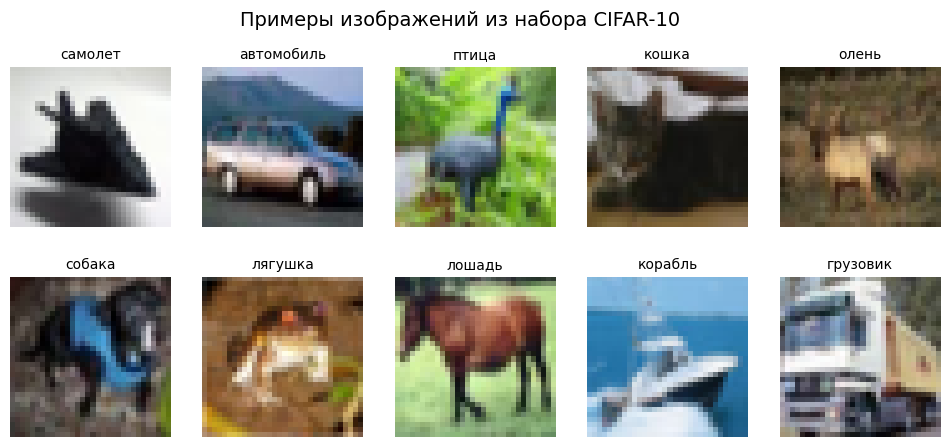


--- Сводка архитектуры CNN ---


C:\Users\vladk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 30, 30, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 13, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,250,858 (4.77 MB)

 Trainable params: 1,250,858 (4.77 MB)

 Non-trainable params: 0 (0.00 B)


--- Начало обучения (требуется несколько минут) ---
Epoch 1/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 32s 39ms/step - accuracy: 0.4408 - loss: 1.5310 - val_accuracy: 0.5827 - val_loss: 1.1672
Epoch 2/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - accuracy: 0.5985 - loss: 1.1285 - val_accuracy: 0.6615 - val_loss: 0.9448
Epoch 3/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - accuracy: 0.6614 - loss: 0.9588 - val_accuracy: 0.7115 - val_loss: 0.8287
Epoch 4/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - accuracy: 0.7013 - loss: 0.8524 - val_accuracy: 0.7188 - val_loss: 0.8032
Epoch 5/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - accuracy: 0.7246 - loss: 0.7862 - val_accuracy: 0.7454 - val_loss: 0.7333
Epoch 6/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - accuracy: 0.7441 - loss: 0.7262 - val_accuracy: 0.7599 - val_loss: 0.6948
Epoch 7/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 32s 41ms/step - accuracy: 0.7591 - loss: 0.6809 - val_accuracy: 0.7701 - val_loss: 0.6750
Epoch 8/15
782/782 ━━━━━━━━━━━━━━━━━━

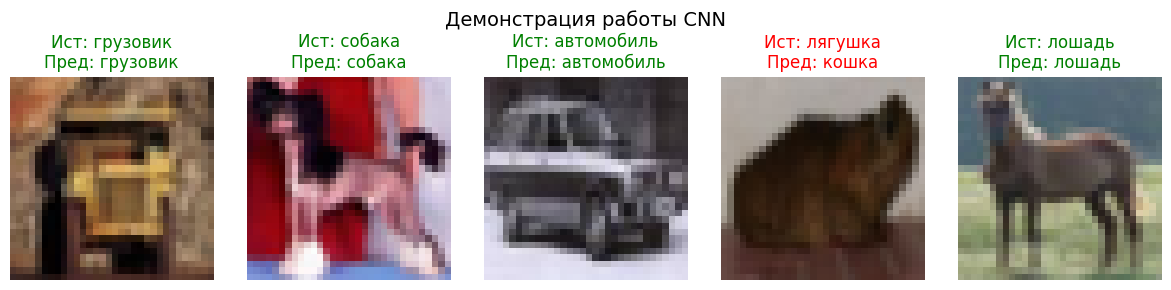

In [ ]:
##Классификация цветных изображений с помощью CNN (CIFAR-10)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np

# Установка Seed для воспроизводимости
tf.random.set_seed(42)

# --- 1. Загрузка и подготовка данных (CIFAR-10) ---

print("Загрузка и подготовка данных CIFAR-10...")

# Загрузка набора данных CIFAR-10.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# 1.1. Нормализация (Масштабирование)
# Пиксели (0-255) -> (0.0-1.0)
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# 1.2. Преобразование меток в One-Hot Encoding
NUM_CLASSES = 10
y_train_cat = to_categorical(y_train, num_classes=NUM_CLASSES)
y_test_cat = to_categorical(y_test, num_classes=NUM_CLASSES)

print(f"Обучающая выборка X: {x_train.shape} (32x32x3)")

# --- 2. Визуализация: Классы и примеры ---

CLASS_NAMES = ['самолет', 'автомобиль', 'птица', 'кошка', 'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle('Примеры изображений из набора CIFAR-10', fontsize=14)

for i, ax in enumerate(axes.flatten()):
    # Находим первый элемент для каждого класса
    idx = np.where(y_train == i)[0][0]
    ax.imshow(x_train[idx])
    ax.set_title(CLASS_NAMES[i], fontsize=10)
    ax.axis('off')
plt.show()

# --- 3. Построение архитектуры CNN ---

INPUT_SHAPE = x_train.shape[1:] # (32, 32, 3)

model = Sequential([
    # Блок 1: Основные признаки
    Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_SHAPE, padding='same'),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    # Блок 2: Более сложные признаки
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    # Классификатор (MLP-часть)
    Flatten(), 
    Dense(512, activation='relu'),
    Dropout(0.5),
    
    # Выходной слой
    Dense(NUM_CLASSES, activation='softmax') 
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

print("\n--- Сводка архитектуры CNN ---")
model.summary()

# --- 4. Обучение модели (Fit) ---

print("\n--- Начало обучения (требуется несколько минут) ---")

history = model.fit(
    x_train, y_train_cat,
    epochs=15, 
    batch_size=64,
    validation_data=(x_test, y_test_cat),
    verbose=1
)

# --- 5. Оценка и демонстрация предсказания ---

loss, accuracy = model.evaluate(x_test, y_test_cat, verbose=0)
print(f"\n✅ Финальная точность на тестовых данных: **{accuracy*100:.2f}%**")

# 6.2. Предсказание на 5 случайных тестовых изображениях
print("\n--- Предсказание на случайных тестовых примерах ---")
fig, axes = plt.subplots(1, 5, figsize=(12, 3))
fig.suptitle('Демонстрация работы CNN', fontsize=14)

test_indices = np.random.choice(len(x_test), 5, replace=False)

for i, ax in enumerate(axes):
    sample_index = test_indices[i]
    sample_image = x_test[sample_index]
    sample_label_idx = y_test[sample_index][0]
    
    sample_input = sample_image[np.newaxis, ...] 
    
    predictions = model.predict(sample_input, verbose=0)
    predicted_class_idx = np.argmax(predictions[0])
    
    true_label = CLASS_NAMES[sample_label_idx]
    predicted_label = CLASS_NAMES[predicted_class_idx]
    
    # Визуализация
    ax.imshow(sample_image)
    ax.set_title(f"Ист: {true_label}\nПред: {predicted_label}", 
                 color='green' if sample_label_idx == predicted_class_idx else 'red')
    ax.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## 🖼️ Дополнительная задача: Классификация изображений (CIFAR-10)

Эта задача идеально демонстрирует возможности **Свёрточных нейронных сетей (CNN)**, которые являются стандартом в обработке изображений.

-----

### 1\. 🎯 Суть задачи: Распознавание объектов на фотографиях

**Цель:** Построить модель, которая классифицирует фотографии, содержащие реальные объекты, на один из 10 классов.

**Набор данных:** **CIFAR-10** (Canadian Institute For Advanced Research). Это набор из **60 000** цветных (RGB) изображений размером **32x32 пикселя**, разделённых на 10 классов (самолёт, автомобиль, птица, кошка, олень, собака, лягушка, лошадь, корабль, грузовик).

**Сложность:** В отличие от MNIST, где фон был чёрно-белый и простой, изображения CIFAR-10 цветные, имеют сложные фоны и вариации освещения, что требует более продвинутой архитектуры.

-----

### 2\. 🧠 Архитектура нейронной сети: Свёрточная нейронная сеть (CNN)

Для цветных изображений мы используем **Свёрточную нейронную сеть (Convolutional Neural Network, CNN)**. Она имитирует зрительную кору мозга и имеет три ключевых типа слоёв:

#### 2.1. Ключевые слои CNN

1.  **Свёрточный слой (Conv2D):**

      * **Роль:** Извлекает признаки из изображения с помощью **фильтров (ядер)**. Каждый фильтр "проходит" по изображению, обнаруживая локальные паттерны, такие как края, текстуры или углы.
      * **Особенность:** В отличие от MLP, CNN сохраняет пространственную структуру изображения.

2.  **Слой субдискретизации/Пулинга (Pooling):**

      * **Роль:** Уменьшает размерность карты признаков (разрешение), сохраняя наиболее важную информацию.
      * **Преимущество:** Делает модель **инвариантной** (устойчивой) к небольшим сдвигам, поворотам или масштабированию объекта на изображении.

3.  **Полносвязный слой (Dense/Classifier):**

      * **Роль:** После извлечения признаков слоями Conv2D, данные "разворачиваются" (Flatten) и подаются на стандартные слои MLP для финальной классификации.

#### 2.2. Архитектурная схема

Модель CIFAR-10 обычно строится как последовательность блоков:

| Блок | Слой | Выходная форма | Роль |
| :---: | :--- | :--- | :--- |
| **Вход** | RGB-изображение | $(32, 32, 3)$ | Цветное изображение ($32 \times 32$ пикселей с 3 цветовыми каналами). |
| **1** | Conv2D (32 фильтра) | $(32, 32, 32)$ | Обнаружение базовых **цветовых и граничных признаков**. |
| **2** | MaxPooling | $(16, 16, 32)$ | Уменьшение разрешения в 2 раза, повышение устойчивости. |
| **3** | Conv2D (64 фильтра) | $(16, 16, 64)$ | Обнаружение более **сложных текстур и комбинаций линий**. |
| **4** | MaxPooling | $(8, 8, 64)$ | Дальнейшее уменьшение размера. |
| **5** | Flatten | $(4096,)$ | **Разворачивание** карты признаков в одномерный вектор. |
| **6** | Dense (512 нейронов) | $(512,)$ | Высший уровень классификации. |
| **7** | Dense (10 нейронов) | $(10,)$ | **Выход Softmax** для 10 классов. |
